# Exploring balances in and out

There's a few discrepancies in the data that I want to explore: 

* figure out why there was a swap between 2009 for retail and consumer finance revolving debt
* figure out how many non zero balances there are for
    * auto bank
    * retail
    * CFR
    * and see if that explains jumps in balances 
 
## Setting up 

In [1]:
# Setting up 

import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

sample = "~//projects//equifaxmacro_proj//EquiFax3//2_10_Percent_Sample_Construction//output//sample//"
output_3 = "~//projects//equifaxmacro_proj//EquiFax3//3_Balance_In_And_Out_Construction//output//"

In [2]:
biao_str = output_3 + "1_balance_in_and_out.parquet"

def monyr(monnum):

    mon = (monnum + 5) % 12 + 1

    if mon < 10: 
        MONNUM = "0" + str(mon)
    else: 
        MONNUM = str(mon)

    YRNUM = int(((monnum - mon)/12) + 2006)

    DATE = str(YRNUM) + MONNUM
    
    return DATE;

cols = [monyr(monnum) for monnum in range(1, 196)]

iao = pd.read_parquet(biao_str, columns = cols).reset_index()

## why was there a swap in the in the number of consumer finance revolving balances? 

In [ ]:
iao.head()

In [ ]:
iao['num'] = iao.count(axis = 1)

In [ ]:
iao.num.value_counts()

In [ ]:
# only keep tradelines that are active during this time period
biao = iao[iao.num != 0]

In [ ]:
biao.shape

In [ ]:
biao = biao.drop('num', axis =1).reset_index()

In [ ]:
biao.head()

In [ ]:
# this shows the massive jumps
biao.drop(['consumer_id', 'trade_id'], axis = 1).groupby('product_category').count()

In [ ]:
biao_2 = biao[biao.product_category.isin(['CFR', 'RT'])].set_index(['consumer_id', 'trade_id', 'product_category'])

In [ ]:
biao_isnan = np.isnan(biao_2) * 1 
biao_g1 = (biao_2 > 0) * 1

In [ ]:
# how many non-zero tradelines are there each month? By type
biao_g1.reset_index().drop(['consumer_id', 'trade_id'], axis = 1).groupby('product_category').sum()

In [ ]:
# how many zero tradelines are there? 
# zero means isnan returns false, and >0 also returns false

biao_0 = ((biao_isnan + biao_g1) == 0) * 1
biao_0.reset_index().drop(['consumer_id', 'trade_id'], axis = 1).groupby('product_category').sum()

# percentiles for non-zero balances

In [ ]:
biao_replace_0 = biao.set_index(['consumer_id','trade_id', 'product_category']).replace(0, np.NaN)

In [ ]:
biao_replace_0.head()

In [ ]:
biao_replace_0.reset_index().drop(['consumer_id', 'trade_id'], axis = 1).groupby('product_category').describe()

So it looks like the balances jump drastically even when you take out the zero balances 

Interestingly enough, it looks like the retrail balances don't jump too much. 

In [ ]:
biao.head(10)

In [ ]:
a  = biao[['consumer_id', 'product_category']].value_counts()
a.head()

In [ ]:
a.reset_index().consumer_id.value_counts().value_counts()

so, two thirds of people have both RT and CFR loans. What kind of tradelines enter and exit? 

In [ ]:
diff = pd.DataFrame(np.diff((biao_isnan == 0) * 1))

In [ ]:
diff.index = biao_isnan.index

In [ ]:
diff.head(10)

In [ ]:
diff = diff[diff[1] != 0]

In [ ]:
# number of people with a CFR or RT tradeline entering/leaving
len(diff.reset_index().consumer_id.unique())

Wait this is like a third of the sample 

In [ ]:
diff.reset_index()[['consumer_id','product_category']].value_counts().reset_index().consumer_id.value_counts().value_counts()

Okay, the vast majority of people swapped tradelines of some sort it looks like 

# retail tradelines that entered

In [ ]:
RT_exit = diff[diff[1] == 1].reset_index()
RT_exit.head()

In [ ]:
RT_exit = RT_exit.loc[RT_exit.product_category == "RT", 'trade_id']

In [ ]:
RT_exit_bal = biao[biao.trade_id.isin(RT_exit)].set_index(['consumer_id', 'product_category', 'trade_id'])

In [ ]:
RT_exit_bal.reset_index().groupby('product_category').count()

Okay, so a lot of these tradelines changed classifications 

In [ ]:
RT_exit_bal.reset_index().groupby('product_category').mean()

  Even after looking at all kinds of debt, it looks like 101k are bankcards that changed type and about 475k are CFR that changed type. Of the 1.2 million new RT tradelines, this explains a bit under half. 
  
  ## how many retail tradelines left that month? 

In [ ]:
RT_ent = diff[diff[1] == -1].reset_index()
RT_ent = RT_ent.loc[RT_ent.product_category == "RT", 'trade_id']

In [ ]:
RT_ent_bal = biao[biao.trade_id.isin(RT_ent)].set_index(['consumer_id', 'product_category', 'trade_id'])

In [ ]:
RT_ent_bal.reset_index().groupby('product_category').count()

In [ ]:
RT_ent_bal.reset_index().groupby('product_category').mean()

## What about CFR tradelines that all left? Their balances all jumped too 

In [ ]:
CFR_exit = diff[diff[1] == -1].reset_index()
CFR_exit = CFR_exit.loc[CFR_exit.product_category == "CFR", 'trade_id']
CFR_exit_bal = biao[biao.trade_id.isin(CFR_exit)].set_index(['consumer_id', 'product_category', 'trade_id'])

In [ ]:
CFR_exit_bal.reset_index().groupby('product_category').count()

In [ ]:
CFR_exit_bal.reset_index().groupby('product_category').mean()

In [ ]:
# about half of the tradelines that disappeared became retail tradelines 
CFR_exit_bal.head(10)

In [ ]:
# let's look at the people, not just the tradelines 

CFR_exit = diff[diff[1] == -1].reset_index()
CFR_exit_cids = CFR_exit.loc[CFR_exit.product_category == "CFR", 'consumer_id']
CFR_exit_cids_bal = biao[biao.consumer_id.isin(CFR_exit_cids)].set_index(['consumer_id', 'product_category', 'trade_id'])

In [ ]:
CFR_exit_cids_bal.head(100)

In [ ]:
biao.loc[biao.product_category=="CFR", 'consumer_id'].value_counts().value_counts()

In [ ]:
CFR = biao[biao.product_category=="CFR"]

In [ ]:
CFR = CFR.replace(0, np.NaN)

In [ ]:
CFR.iloc[:, 3:].describe()

It looks like most of the balances that left had lower balances on average (129 as opposed to closer to 175). Across a lot of balances, this makes a difference. 

Of the ones that went to retail, their balances were higher (about 220). 

I guess we should do this by person too? Not today though. 

## Spike in Auto Bank Lease

In [ ]:
newcols = ['20150' + str(mon) for mon in range(5, 10)] + ['201510', '201511']

In [ ]:
all_tl = pd.read_parquet(biao_str, columns = newcols)

In [ ]:
all_tl = all_tl.reset_index()

In [ ]:
abl = all_tl[all_tl.product_category == "AB1"]
abl.shape

In [ ]:
abl['num'] = abl.count(axis = 1)
abl.num.value_counts()

In [ ]:
abl = abl[abl.num != 3].drop('num', axis = 1)

In [ ]:
abl.count()

In [ ]:
abl.mean()

Again, there seems to be a drop in the number of tradelines the same month the balances jump

In [ ]:
abl = abl.set_index(['consumer_id', 'product_category', 'trade_id'])

In [ ]:
diff = pd.DataFrame(np.diff((~np.isnan(abl)) * 1))

In [ ]:
diff.head()

In [ ]:
diff.index = abl.index

In [ ]:
diff.head()

In [ ]:
left = diff[diff[2]==-1]

In [ ]:
left_ids = left.reset_index().trade_id

In [ ]:
abl = abl.reset_index()
abl.head()

In [ ]:
abl_left = abl[abl.trade_id.isin(left_ids)]

In [ ]:
abl_left.describe()

The balaces are much lower than the average loan

In [ ]:
all_tl_abl_left = all_tl[all_tl.trade_id.isin(left_ids)]

In [ ]:
all_tl_abl_left.shape

In [ ]:
abl_left.shape

In [ ]:
all_tl_abl_left.product_category.value_counts()

In [ ]:
equal_zero = (abl_left == 0)

In [ ]:
equal_zero.sum()

In [ ]:
equal_zero.shape

Okay, so it looks like the jump in balances is just because a lot of zero balances were deleted. 

## spike in retail july 2013 

In [ ]:
cols3 = ['201306', '201307', '201308']

rt_all = pd.read_parquet(biao_str, columns =cols3)

In [ ]:
rt_all.head()

In [ ]:
# we only want to look at the retail tradelines
rt_all = rt_all.reset_index()

In [ ]:
retail = rt_all[rt_all.product_category=="RT"]
retail.shape

In [ ]:
retail.head()

In [ ]:
retail.describe()

In [ ]:
retail = retail.drop('index', axis = 1)
retail['num'] = retail.count(axis = 1)
retail = retail[retail.num != 3]
retail.shape

In [ ]:
retail.drop('num', axis = 1, inplace = True)

In [ ]:
retail.head()

In [ ]:
by_person = retail.groupby('consumer_id').sum()

In [ ]:
by_person = by_person.sort_values('201307', ascending = False)

In [ ]:
by_person.head()

In [ ]:
retail[retail.consumer_id.isin([14605648, 10082721])]

lol just a data error

### How many people enter each month? 

In [ ]:
biao_str = output_3 + "1_balance_in_and_out.parquet"

cols = ['first_c']

first = pd.read_parquet(biao_str, columns = cols)

In [ ]:
first = first.reset_index(level = 'consumer_id')
first.head()

In [ ]:
hmmm = first.groupby('consumer_id').min()

In [ ]:
hmmm.first_c.value_counts().sort_index()

## Consumer finance and retail debt

* please redo this graph (with the number of tradelines) but combines retail and consumer finance and drop any tradelines that are zero throughout so that we can see if this is just a coding issue from equifax.

In [ ]:
# filter for CFR and retail debt

In [3]:
iao = iao[iao.product_category.isin(['CFR', 'RT'])]

In [4]:
iao.shape

(20928931, 198)

In [5]:
iao = iao.set_index(['consumer_id', 'trade_id', 'product_category'])

In [6]:
# we just want to know which ones have all zero balances

tf = (iao > 0) * 1

In [7]:
tf['sum'] = tf.sum(axis = 1)

In [8]:
tf['sum'].head()

consumer_id  trade_id   product_category
2            264760648  RT                  0
             343581827  RT                  0
             484441807  RT                  0
             488067225  RT                  4
             865192063  RT                  0
Name: sum, dtype: int64

In [9]:
tf = tf[tf['sum'] != 0] 

In [10]:
tf.shape

(11425203, 196)

In [11]:
nonzero_ids = tf.reset_index()['trade_id']

In [12]:
iao = iao.reset_index()
iao = iao[iao.trade_id.isin(nonzero_ids)]

In [13]:
iao.shape

(11588148, 198)

<AxesSubplot:>

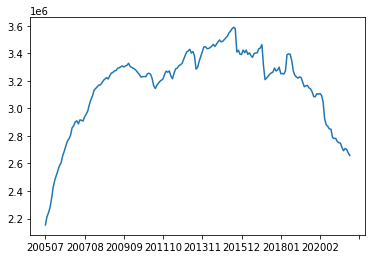

In [17]:
iao.count()[3:].plot()

In [ ]:
iao.mean()[3:].plot()